In [59]:
import IPython
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sys ; sys.path.append('../')
from model.network_architecture import autoencoder
from tqdm import tqdm
from evaluacion import *

In [68]:
CARPETA = '/home/martin/deep-dereverb/model/ckpts/'
pesos = glob.glob(CARPETA+'*.hdf5')
pesos.sort()
PESOS = '/home/martin/deep-dereverb/CL/model/ckpts/ordenado_earlyreverb/weights.03-0.0027.hdf5'
#PESOS = pesos[-1]
modelo = autoencoder()
modelo.load_weights(PESOS)

In [82]:
reverb_list = glob.glob('/home/martin/deep-dereverb/CL/data/train/reverb/**/*.npy', recursive=True)
clean_list =glob.glob('/home/martin/deep-dereverb/CL/data/train/clean/**/*.npy', recursive=True)
reverb_list.sort(); clean_list.sort()

In [83]:
print(reverb_list[-2006])
audio_in = np.load(reverb_list[-2006])
audio_target = np.load(clean_list[-2006])
espectro_in = gen_stft(audio_in)
espectro_target = gen_stft(audio_target)

/home/martin/deep-dereverb/CL/data/train/reverb/161152_2.35_.npy


In [84]:
espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
espectro_out = espectro_out.reshape(256,256)

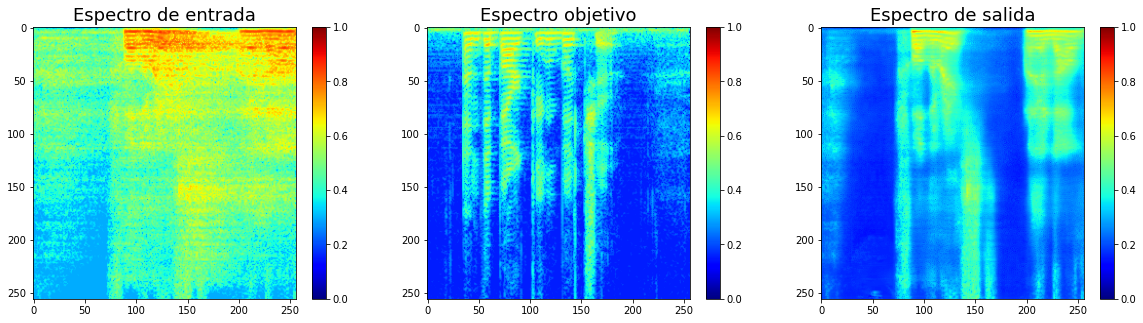

In [85]:
plt.figure(1, figsize=(20,5))
plt.subplot(1,3,1);plt.title('Espectro de entrada', size=18)
plt.imshow(espectro_in, aspect='auto', vmin=0, vmax=1, cmap='jet');plt.colorbar()
plt.subplot(1,3,2);plt.title('Espectro objetivo', size=18)
plt.imshow(espectro_target, aspect='auto', vmin=0, vmax=1, cmap='jet');plt.colorbar()
plt.subplot(1,3,3);plt.title('Espectro de salida', size=18) 
plt.imshow(espectro_out, aspect='auto', vmin=0, vmax=1, cmap='jet');plt.colorbar()
plt.savefig('funcionamiento.png')

In [73]:
audio_in= frame_to_raw(espectro_in)
audio_out = frame_to_raw(espectro_out)
audio_target = frame_to_raw(espectro_target)

In [74]:
fs = 16000
print('Audio con reverb (entrada)')
IPython.display.display(IPython.display.Audio(audio_in, rate=fs))
print('Audio anecoico (objetivo)')
IPython.display.display(IPython.display.Audio(audio_target, rate=fs))
print('Audio dereverberado (resultado)')
IPython.display.display(IPython.display.Audio(audio_out, rate=fs))

Audio con reverb (entrada)


Audio anecoico (objetivo)


Audio dereverberado (resultado)


# Evaluando metricas

In [78]:
def get_metricas(clean, reverb, fs):
    SRMR = srmr.srmr(reverb, fs)[0]
    SDR, _, _, _ = mir_eval.separation.bss_eval_sources(clean, reverb, compute_permutation=True)
    ESTOI = pystoi.stoi(clean, reverb, fs, extended = True)
    print('SDR: {}\t SRMR: {}\t ESTOI: {}'.format(SDR, SRMR, ESTOI))
    return SRMR, SDR, ESTOI
_ = get_metricas(audio_target, audio_in, 16000)
_ = get_metricas(audio_target, audio_out, 16000)

SDR: [-23.52157154]	 SRMR: 1.4115605451287219	 ESTOI: 0.06786912680745444
SDR: [-21.63299558]	 SRMR: 3.8119617366513303	 ESTOI: 0.04965455337314532


In [62]:
indices = np.random.choice(np.arange(0,len(reverb_list)), 100)

SRMR_reverb = []                                                                                                                         
SDR_reverb = []                                                                                                                          
ESTOI_reverb = []                                                                                                                        

SRMR_dereverb = []                                                                                                                       
SDR_dereverb = []                                                                                                                        
ESTOI_dereverb = [] 

for i in tqdm(indices):
    audio_in = np.load(reverb_list[i])
    audio_target = np.load(clean_list[i])
    
    espectro_in = gen_stft(audio_in)
    espectro_target = gen_stft(audio_target)
    
    espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
    espectro_out = espectro_out.reshape(256,256)
    
    dereverb = frame_to_raw(espectro_out)
    clean = frame_to_raw(espectro_target)
    reverb = frame_to_raw(espectro_in)
    
    # get metriciis for clean-reverb                                                                                                       
    srmr_, sdr, estoi = get_metricas(clean, reverb, fs)                                                                                   
    SRMR_reverb.append(srmr_)                                                                                                             
    SDR_reverb.append(sdr)                                                                                                               
    ESTOI_reverb.append(estoi)                                                                                                           

    # get metrics for clean-dereverb                                                                                                     
    srmr_, sdr, estoi = get_metricas(clean, dereverb, fs)                                                                                 
    SRMR_dereverb.append(srmr_)                                                                                                           
    SDR_dereverb.append(sdr)                                                                                                             
    ESTOI_dereverb.append(estoi)
    
    

  1%|█                                                                                                       | 1/100 [00:08<13:41,  8.30s/it]

SDR: [-5.47807494]	 SRMR: 2.024147635366565	 ESTOI: 0.2913673607292307
SDR: [-3.57345201]	 SRMR: 2.6994056058804374	 ESTOI: 0.6091024166376037


  2%|██                                                                                                      | 2/100 [00:16<13:37,  8.34s/it]

SDR: [-8.40502998]	 SRMR: 3.297682421399665	 ESTOI: 0.34383483299922013
SDR: [-51.14560085]	 SRMR: 48.64624707110394	 ESTOI: 0.5588503167715793


  3%|███                                                                                                     | 3/100 [00:24<13:24,  8.30s/it]

SDR: [-4.90906826]	 SRMR: 5.175345868895282	 ESTOI: 0.360146116657043
SDR: [-23.94398206]	 SRMR: 48.95749415496731	 ESTOI: 0.6226748105738076


  4%|████▏                                                                                                   | 4/100 [00:32<13:07,  8.21s/it]

SDR: [-10.84580318]	 SRMR: 1.5388173016806133	 ESTOI: 0.38606376568628525
SDR: [-11.81952613]	 SRMR: 5.1524810009016635	 ESTOI: 0.5270796688790249


  5%|█████▏                                                                                                  | 5/100 [00:41<12:56,  8.18s/it]

SDR: [-2.70255133]	 SRMR: 2.5335822527969714	 ESTOI: 0.3114957597176296
SDR: [-0.85065488]	 SRMR: 4.811491449520867	 ESTOI: 0.5325369802867107


  6%|██████▏                                                                                                 | 6/100 [00:49<12:52,  8.22s/it]

SDR: [-3.45362557]	 SRMR: 3.4248037105317692	 ESTOI: 0.3725557146937956
SDR: [-3.84222361]	 SRMR: 7.038852307096712	 ESTOI: 0.6992348287024315


  7%|███████▎                                                                                                | 7/100 [00:57<12:45,  8.23s/it]

SDR: [-5.63216079]	 SRMR: 5.611025832452116	 ESTOI: 0.31084261717102823
SDR: [-2.28741697]	 SRMR: 13.19171579169553	 ESTOI: 0.5675247430797549


  8%|████████▎                                                                                               | 8/100 [01:05<12:30,  8.15s/it]

SDR: [-4.29583939]	 SRMR: 2.103912812014116	 ESTOI: 0.3185078637963267
SDR: [-6.26426089]	 SRMR: 4.528859925674063	 ESTOI: 0.6396315617707539


  9%|█████████▎                                                                                              | 9/100 [01:13<12:17,  8.11s/it]

SDR: [-3.08914217]	 SRMR: 3.9111624966570244	 ESTOI: 0.5297496150494392
SDR: [-7.3377812]	 SRMR: 5.602374071845224	 ESTOI: 0.6989157087221551


 10%|██████████▎                                                                                            | 10/100 [01:21<12:04,  8.05s/it]

SDR: [-3.86768906]	 SRMR: 2.3005374048311125	 ESTOI: 0.46588538369344107
SDR: [-6.03993002]	 SRMR: 8.485195709643857	 ESTOI: 0.6594292168310291


 11%|███████████▎                                                                                           | 11/100 [01:29<11:53,  8.02s/it]

SDR: [-5.32793738]	 SRMR: 3.4044090633941084	 ESTOI: 0.2914728702342468
SDR: [-7.70855739]	 SRMR: 5.985098456472254	 ESTOI: 0.7172663017900834


 12%|████████████▎                                                                                          | 12/100 [01:37<11:38,  7.94s/it]

SDR: [-5.51597612]	 SRMR: 1.6324236447459122	 ESTOI: 0.3118495926000998
SDR: [-2.16718816]	 SRMR: 5.6508730802412845	 ESTOI: 0.6362250276082051


 13%|█████████████▍                                                                                         | 13/100 [01:45<11:25,  7.88s/it]

SDR: [-3.9433853]	 SRMR: 3.5678457951451197	 ESTOI: 0.3469400131640461
SDR: [-5.18223791]	 SRMR: 8.038052385809598	 ESTOI: 0.6364724122883988


 14%|██████████████▍                                                                                        | 14/100 [01:52<11:18,  7.88s/it]

SDR: [-2.65442652]	 SRMR: 1.9521119305001888	 ESTOI: 0.23631664807879846
SDR: [-4.27791576]	 SRMR: 4.470775917732197	 ESTOI: 0.5259569391148968


 15%|███████████████▍                                                                                       | 15/100 [02:01<11:19,  7.99s/it]

SDR: [-2.44002268]	 SRMR: 4.554490797349193	 ESTOI: 0.33775139205961296
SDR: [-4.88496166]	 SRMR: 7.427566196104009	 ESTOI: 0.6728711650907994


 16%|████████████████▍                                                                                      | 16/100 [02:09<11:12,  8.00s/it]

SDR: [-2.85845425]	 SRMR: 2.322300768999094	 ESTOI: 0.40120964907986434
SDR: [-2.60803781]	 SRMR: 5.968031169296156	 ESTOI: 0.7213845366155809


 17%|█████████████████▌                                                                                     | 17/100 [02:17<11:07,  8.05s/it]

SDR: [-3.40819222]	 SRMR: 3.0474480615066537	 ESTOI: 0.42324533850306006
SDR: [-3.13091197]	 SRMR: 8.977430572078822	 ESTOI: 0.6434240971037671


 18%|██████████████████▌                                                                                    | 18/100 [02:25<11:00,  8.05s/it]

SDR: [-2.33401105]	 SRMR: 2.3861197671054915	 ESTOI: 0.19158850806554398
SDR: [-7.64134048]	 SRMR: 1.6793560947237067	 ESTOI: 0.2099174793782653


 19%|███████████████████▌                                                                                   | 19/100 [02:33<10:55,  8.09s/it]

SDR: [-4.41324297]	 SRMR: 3.243728038211559	 ESTOI: 0.4535086431284534
SDR: [-6.36360783]	 SRMR: 5.580575758079934	 ESTOI: 0.6509676312715899


 20%|████████████████████▌                                                                                  | 20/100 [02:41<10:48,  8.11s/it]

SDR: [2.48866438]	 SRMR: 9.15564391592391	 ESTOI: 0.6715804840087778
SDR: [0.72901753]	 SRMR: 11.57927153412693	 ESTOI: 0.6679575535105389


 21%|█████████████████████▋                                                                                 | 21/100 [02:49<10:43,  8.14s/it]

SDR: [-2.04897427]	 SRMR: 3.816715472431728	 ESTOI: 0.36512918327373894
SDR: [-3.49591184]	 SRMR: 8.232280272724507	 ESTOI: 0.5993137223918767


 22%|██████████████████████▋                                                                                | 22/100 [02:58<10:34,  8.14s/it]

SDR: [-6.37135664]	 SRMR: 2.8843655004157176	 ESTOI: 0.3020884841391861
SDR: [-3.81078736]	 SRMR: 10.070376875080816	 ESTOI: 0.583811862715562


 23%|███████████████████████▋                                                                               | 23/100 [03:06<10:26,  8.13s/it]

SDR: [-2.50415623]	 SRMR: 2.2430698426514706	 ESTOI: 0.2533518844008764
SDR: [-5.09825391]	 SRMR: 4.670923184524591	 ESTOI: 0.442414926957864


 23%|███████████████████████▋                                                                               | 23/100 [03:10<10:36,  8.26s/it]


KeyboardInterrupt: 

# Ploteo por epocas

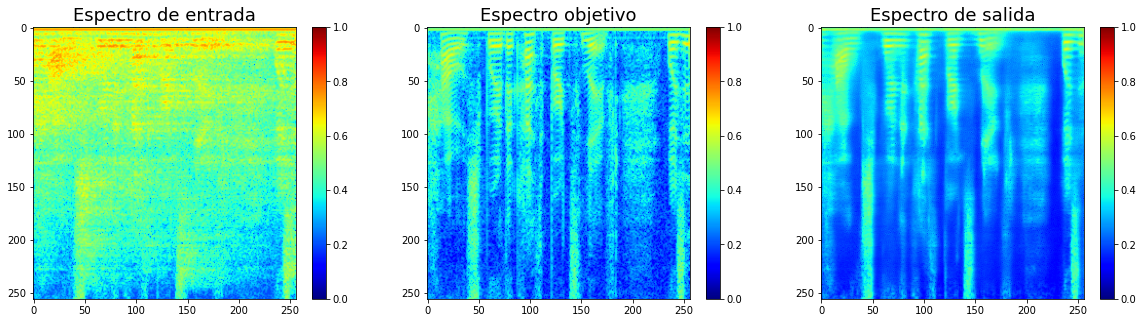

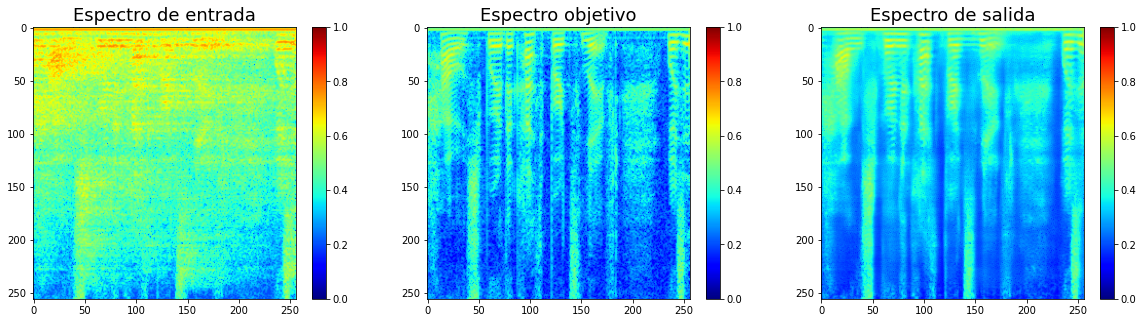

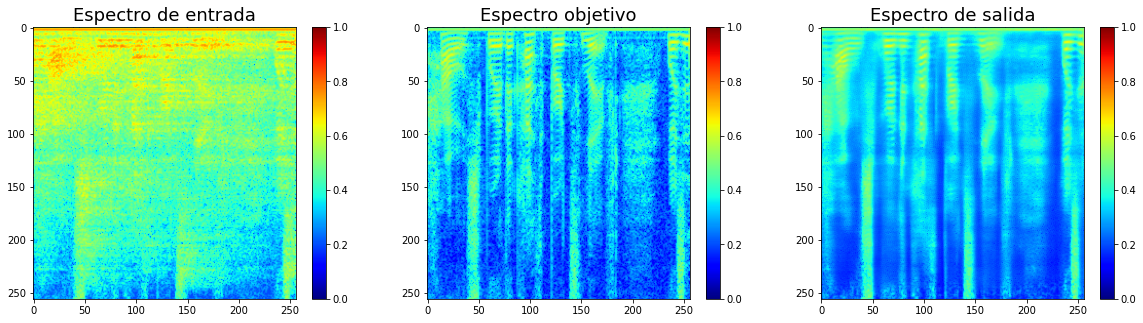

In [11]:
import glob
CARPETA = '/home/martin/deep-dereverb/model/ckpts/mezcla/'
pesos = glob.glob(CARPETA+'*.hdf5')
pesos.sort()
labels = ['Epoca '+p.split('/')[-1].split('.')[1][:2] for p in pesos]

modelo = autoencoder()
reverb_list = glob.glob('/home/martin/deep-dereverb/data/train/real/**/*.npy', recursive=True)
clean_list =glob.glob('/home/martin/deep-dereverb/data/train/clean/**/*.npy', recursive=True)
reverb_list.sort(); clean_list.sort()

for idx,peso in enumerate(pesos):
    modelo.load_weights(peso)
    audio_in = np.load(reverb_list[1])
    audio_target= np.load(clean_list[1])
    
    espectro_in = gen_stft(audio_in)
    espectro_target = gen_stft(audio_target)
    
    espectro_out = modelo.predict([espectro_in.reshape(1,256,256)])
    espectro_out = espectro_out.reshape(256,256)
    
    plt.figure(idx, figsize=(20,5))
    plt.subplot(1,3,1);plt.title('Espectro de entrada', size=18)
    plt.imshow(espectro_in, aspect='auto',vmin=0, vmax=1, cmap='jet');plt.colorbar()
    plt.subplot(1,3,2);plt.title('Espectro objetivo', size=18)
    plt.imshow(espectro_target, aspect='auto',vmin=0, vmax=1, cmap='jet');plt.colorbar()
    plt.subplot(1,3,3);plt.title('Espectro de salida', size=18)
    plt.imshow(espectro_out, aspect='auto',vmin=0, vmax=1, cmap='jet');plt.colorbar()
    plt.savefig('funcionamiento.png')
    

In [31]:
def predict_model(data, modelo):                                                                                                             
  output = [layer.name for layer in modelo.layers]                                                                                           
  outputs = []                                                                                                                               
  output_names = []                                                                                                                          
  inputs = []                                                                                                                                
  input_names = []                                                                                                                           
  for layer in modelo.layers:                                                                                                                
      if hasattr(layer,'is_placeholder'):                                                                                                    
          inputs.append(layer.output)                                                                                                        
          input_names.append(layer.name)                                                                                                     
      elif layer.name in output:                                                                                                             
          outputs.append(layer.output)                                                                                                       
          output_names.append(layer.name)                                                                                                    
      else:                                                                                                                                  
          pass                                                                                                                               
  predict_fn = tf.keras.backend.function(inputs = inputs,outputs=outputs)                                                                    
  activations = predict_fn(data)                                                                                                             
  activations = {name: act for name, act in zip(output_names,activations)}                                                                   
  print('orden de las entradas: /\n',input_names)                                                                                            
  return activations 
PESOS = '/home/martin/deep-dereverb/model/ckpts/mezcla/weights.03-0.0022.hdf5'
modelo = autoencoder()
modelo.load_weights(PESOS)
actvs = predict_model([espectro_in.reshape(1,256,256)], modelo)

orden de las entradas: /
 ['Entrada_reverb']


In [32]:
actvs.keys()

dict_keys(['tf.expand_dims', 'CONV1', 'ACT1', 'CONV2', 'BATCH2', 'ACT2', 'CONV3', 'BATCH3', 'ACT3', 'CONV4', 'BATCH4', 'ACT4', 'CONV5', 'BATCH5', 'ACT5', 'CONV6', 'BATCH6', 'ACT6', 'CONV7', 'BATCH7', 'ACT7', 'CONV8', 'BATCH8', 're_lu', 'up_sampling2d', 'CONV9', 'BATCH9', 'dropout', 're_lu_1', 'add', 'up_sampling2d_1', 'CONV10', 'BATCH10', 'dropout_1', 're_lu_2', 'add_1', 'up_sampling2d_2', 'CONV11', 'BATCH11', 'dropout_2', 're_lu_3', 'add_2', 'up_sampling2d_3', 'CONV12', 'BATCH12', 're_lu_4', 'add_3', 'up_sampling2d_4', 'CONV13', 'BATCH13', 're_lu_5', 'add_4', 'up_sampling2d_5', 'CONV14', 'BATCH14', 're_lu_6', 'add_5', 'up_sampling2d_6', 'CONV15', 'BATCH15', 're_lu_7', 'add_6', 'up_sampling2d_7', 'SALIDA_DEL_DECODER', 're_lu_8', 'CLEAN_PREDICT'])

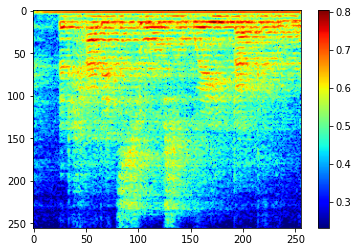

In [33]:
# Recupero la entrada
entrada = actvs['tf.expand_dims'][0,:,:,0]
plt.imshow(entrada, aspect='auto', cmap='jet')
plt.colorbar()

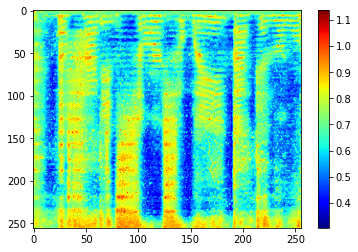

In [37]:
# Recupero la mascara
mascara = actvs['SALIDA_DEL_DECODER'][0,:,:,0]
plt.imshow(mascara, aspect='auto', cmap='jet')
plt.colorbar()
mascara = np.ones(mascara.shape)

In [38]:
espectro_out = entrada * mascara
audio_out = frame_to_raw(espectro_out)

In [39]:
IPython.display.Audio(audio_out, rate = 16000)